Then this is supposed to work

In [1]:
import threading
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../')

from vent.coordinator.control_module import get_control_module   # this is the file to change
from vent.coordinator.message import SensorValues, ControlSettings, Alarm, ControlSettingName

## First, wrap the controller in a thread

In [2]:
class ControllerThread(threading.Thread):
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID        = threadID
        self.name            = name
        self.counter         = counter
        self.ContollInstance = get_control_module(sim_mode=True)

    def run(self):
        while self.counter:
            #     controls actuators to achieve target state
            self.ContollInstance.run()  # run a contol update 
            time.sleep(.01)             # wait 10ms
            self.counter -= 1

    def set_controls(self, exampleCS):
        self.ContollInstance.set_controls(exampleCS)
        
    def get_sensor_values(self):
        # returns SensorValues, include a timestamp and loop counter
        sv = self.ContollInstance.get_sensors_values()
        sv.loop_counter = self.counter
        return sv

    def heartbeat(self):
        print ("%s: %s" % (self.name, time.ctime(time.time())))
        print("Internal counter =" + str(self.counter)+'.\n')


# Set the controls

These are the allowed control settings. Only the first five (PIP, PIP_TIME, PEEP, BPM, INSPIRATION_TIM) can be set. The others are controlled in hardware.

In [5]:
list(ControlSettingName)

[<ControlSettingName.PIP: 1>,
 <ControlSettingName.PIP_TIME: 2>,
 <ControlSettingName.PEEP: 3>,
 <ControlSettingName.BREATHS_PER_MINUTE: 4>,
 <ControlSettingName.INSPIRATION_TIME_SEC: 5>,
 <ControlSettingName.FIO2: 6>,
 <ControlSettingName.TEMP: 7>,
 <ControlSettingName.HUMIDITY: 8>,
 <ControlSettingName.VTE: 9>]

In [6]:
c1 = ControlSettings(name=ControlSettingName.PIP, value=22, min_value=20, \
                          max_value=24, timestamp=time.time())

c2 = ControlSettings(name=ControlSettingName.PIP_TIME, value=0.5, min_value=0.2, \
                          max_value=0.5, timestamp=time.time())

c3 = ControlSettings(name=ControlSettingName.PEEP, value=5, min_value=4, \
                          max_value=6, timestamp=time.time())

c4 = ControlSettings(name=ControlSettingName.BREATHS_PER_MINUTE, value=10, \
                          min_value=18, max_value=22, timestamp=time.time())

c5 = ControlSettings(name=ControlSettingName.INSPIRATION_TIME_SEC, value=2.0, 
                          min_value=1.0, max_value=1.5, timestamp=time.time())

In [7]:
#Set the controls

In [8]:
runtime = 30 # run this for 30 seconds

thread1 = ControllerThread(1, "Controller-1", runtime/0.01) #5sec in 10ms steps

for command in [c1,c2,c3,c4,c5]:
    thread1.set_controls(command)

In [9]:
print(thread1.ContollInstance.Controller.PIP)
print(thread1.ContollInstance.Controller.PIP_time)
print(thread1.ContollInstance.Controller.PEEP)
print(thread1.ContollInstance.Controller.bpm)
print(thread1.ContollInstance.Controller.I_phase)

22
0.5
5
10
2.0


In [10]:
sample_times = 0.05 #get a sample every 50ms

thread1.start()  # Start Controller

ls = []
tt = []
for t in np.arange(0,runtime,sample_times):
    
    #ask for a heartbeat every two seconds
    if t%2==0:
        thread1.heartbeat()
    
    vals = thread1.get_sensor_values()
    ls.append(vals)
    tt.append(time.time())
    
    time.sleep(0.05)



#     instance.get_alarms()
#     instance.get_active_alarms()
#     instance.get_logged_alarms()

Controller-1: Sat Apr 18 17:47:14 2020
Internal counter =3000.0.

Controller-1: Sat Apr 18 17:47:16 2020
Internal counter =2816.0.

Controller-1: Sat Apr 18 17:47:18 2020
Internal counter =2632.0.

Controller-1: Sat Apr 18 17:47:21 2020
Internal counter =2450.0.

Controller-1: Sat Apr 18 17:47:23 2020
Internal counter =2267.0.

Controller-1: Sat Apr 18 17:47:25 2020
Internal counter =2082.0.

Controller-1: Sat Apr 18 17:47:27 2020
Internal counter =1896.0.

Controller-1: Sat Apr 18 17:47:29 2020
Internal counter =1709.0.

Controller-1: Sat Apr 18 17:47:31 2020
Internal counter =1523.0.

Controller-1: Sat Apr 18 17:47:33 2020
Internal counter =1338.0.

Controller-1: Sat Apr 18 17:47:35 2020
Internal counter =1151.0.

Controller-1: Sat Apr 18 17:47:37 2020
Internal counter =970.0.

Controller-1: Sat Apr 18 17:47:39 2020
Internal counter =789.0.

Controller-1: Sat Apr 18 17:47:41 2020
Internal counter =606.0.

Controller-1: Sat Apr 18 17:47:43 2020
Internal counter =423.0.



<function matplotlib.pyplot.legend(*args, **kwargs)>

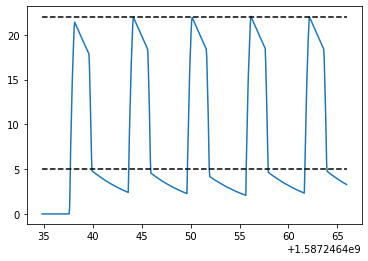

In [11]:
pip = thread1.ContollInstance.Controller.PIP
peep = thread1.ContollInstance.Controller.PEEP

pl.plot(tt, [s.pressure for s in ls], label = 'pressure')
# pl.plot(tt, [s.temp for s in ls], label = "temperatue")
# pl.plot(tt, [s.humidity for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

pl.legend